# Titanic Survival Prediction

Based on "https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting", https://www.kaggle.com/ksmvsn/titanic-survival-python-solution

1. Executive Summary
2. Introduction to the problem
3. Loading and exploring data
4. Feature engineering
5. Predictions
6. Conclusion

## 1. Executive Summary

## 2. Introduction to the problem

(From Kaggle)

_The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships._

_One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class._

_In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy._

## 3. Loading and exploring data

### 3.1 Loading libraries and data

In [2]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import seaborn as sns
sns.set_style('whitegrid')

C:\Users\rianashwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
full_data = training_data
full_data = full_data.append(test_data)
full_data.describe(include='all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


### 3.2 Missing Data

In [4]:
full_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

From the above, we can see 'Cabin' has a high number of missing values, as well as 'Age'. 'Embarked' and 'Fare' are missing 2 and 1 values/value respectively.

Below is a description of each of the columns provided in the dataset.

!["Description of each field"](Columns.png)

### 3.3 Explore the most important variables

#### 3.3.1 How many people survived the titanic? (and how many did not?)

Text(0.5,1,'Survival')

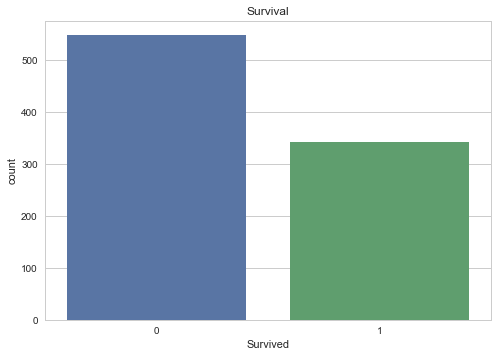

In [5]:
sns.countplot(x='Survived', data=training_data).set_title('Survival')

From here, a lot more people did not survive than survive. Let's study survival by gender:

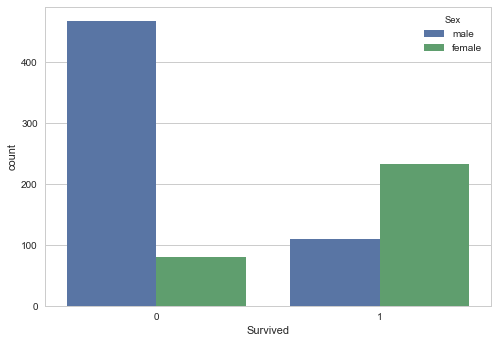

In [6]:
sns.countplot(x='Survived', data=training_data, hue='Sex')

From here, females were more likely to survive than males. Let's study survival by Pclass:

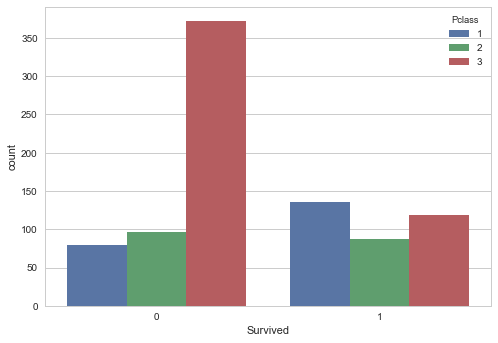

In [7]:
sns.countplot(x='Survived', data=training_data, hue='Pclass')

It seems that if you were in 3rd class, chances are you would not survive.

Text(0.5,1,'Males')

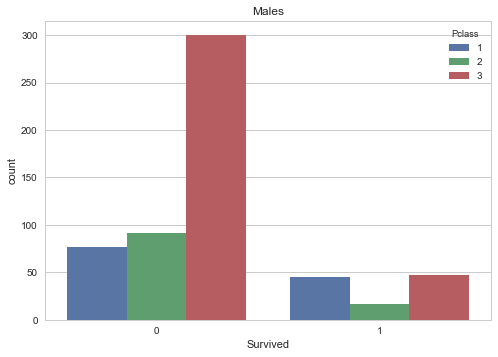

In [8]:
sns.countplot(x='Survived', data=training_data[training_data['Sex']=="male"], hue='Pclass').set_title('Males')

Text(0.5,1,'Females')

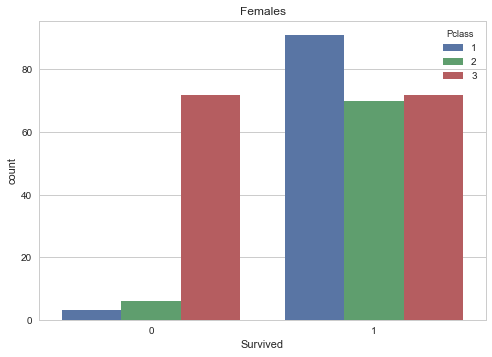

In [9]:
sns.countplot(x='Survived', data=training_data[training_data['Sex']=="female"], hue='Pclass').set_title('Females')

From the two graphs above, we note the following:

1. If you were 3rd class, you are far more likely to not survive compared to 1st or 2nd class, regardless of gender. However, this effect is a litte more pronounced for females in 3rd class.

2. For those who survived, chances are notably higher for females in 1st class.

Overall, 1st and 2nd class are almost guaranteed survival for females, while 3rd class is almost guaranteed non-survival for males.

From here, it makes sense to create a standalone variable which is a combo of Pclass and gender. Let's do that in the next phase of this workbook.

## 4. Feature Engineering

### 4.1 Combo of Pclass and Gender

In [10]:
full_data['Pclass_Gender'] = full_data.apply(lambda row: str(row['Pclass']) + row['Sex'], 
                                                   axis=1)

full_data['Pclass_Gender'].head(10)

0      3male
1    1female
2    3female
3    1female
4      3male
5      3male
6      1male
7      3male
8    3female
9    2female
Name: Pclass_Gender, dtype: object

### 4.2 Extracting title from name

In [11]:
full_data['Title'] = full_data.apply(lambda row: row['Name'].partition(", ")[2].partition(". ")[0], axis=1)
full_data['Title'].value_counts()   

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Jonkheer          1
the Countess      1
Mme               1
Capt              1
Sir               1
Dona              1
Don               1
Lady              1
Name: Title, dtype: int64

Some of these can be aggregated together. Let's
- change Ms and Mlle to Miss (assume Mlle stands for Mademoiselle)
- change Mme to Mrs (assume Mme stands for Madame)
- everything else to 'Rare'

In [12]:
rare_title = ['Dona', 'Jonkheer','Lady', 'Don', 'Capt', 'Sir', 'the Countess', 'Major', 'Col', 'Dr', 'Rev']
full_data['Title'].replace(['Ms', 'Mlle'], 'Miss', inplace=True)
full_data['Title'].replace(['Mme'], 'Mrs', inplace=True)
full_data['Title'].replace(rare_title, 'Rare', inplace=True)
full_data['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

Let's study survival rates by title:

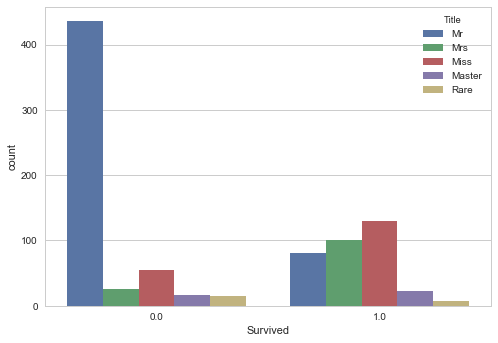

In [13]:
sns.countplot(x='Survived', data=full_data[(full_data['Survived'].notnull())], hue='Title')

### 4.3 Groups of people travelling (and therefore sticking) together

#### 4.3.1 Families

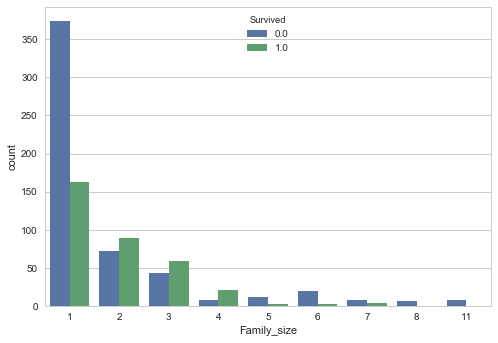

In [14]:
full_data['Family_size'] = full_data['SibSp'] + full_data['Parch'] + 1
sns.countplot(x='Family_size', data=full_data[(full_data['Survived'].notnull())], hue='Survived')

From the above, we see that solo travellers were more likely to die. 

People with small families (up to 4) were more likely to survive than die These chances drop notably once family size is 5 or more.

__4.2.3 What about people who travel together on same ticket but are not family members__

Let's figure out how many people are travelling on the same ticket, and create a new variable.

In [15]:
tickets_dict = full_data['Ticket'].value_counts().to_dict()
full_data['Ticket_size'] = full_data.apply(lambda row: tickets_dict[row['Ticket']], axis=1)

Now, let's take the larger of family size vs ticket size and create a new variable called 'Group' size.

In [16]:
full_data['Group_size'] = full_data[['Family_size',"Ticket_size"]].max(axis=1)
full_data[['Family_size',"Ticket_size",'Group_size']].head(20)

,Family_size,Ticket_size,Group_size
0,2,1,2
1,2,2,2
2,1,1,1
3,2,2,2
4,1,1,1
5,1,1,1
6,1,2,2
7,5,5,5
8,3,3,3
9,2,2,2


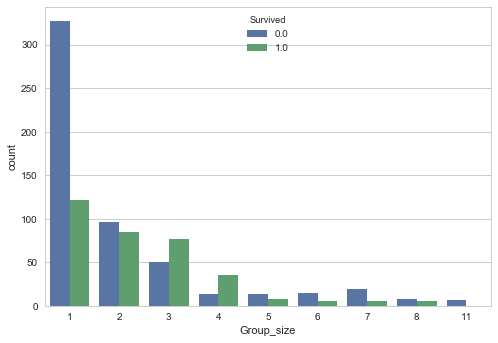

In [17]:
sns.countplot(x='Group_size', data=full_data[(full_data['Survived'].notnull())], hue='Survived')

From here, we see that while people traveling in two's now are more likely to die than survive, as opposed to when we were just analysing family size only.

Let's go ahead and discretize the family size variable now.

In [18]:
full_data['Group_size_range'] = full_data.apply(lambda row: 'single' if row['Group_size'] == 1
                                                 else ('duo' if row['Group_size'] == 2 
                                                       else('small_group' if row['Group_size'] > 2 and row['Group_size'] < 5
                                                            else 'large_group')),
                                                       axis=1)

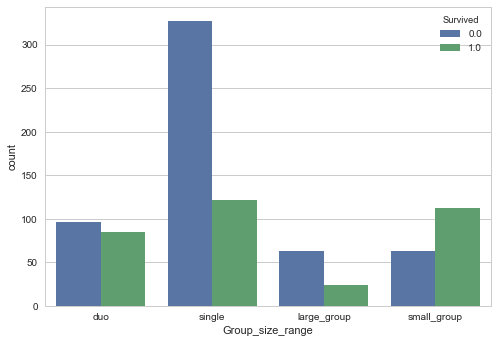

In [19]:
sns.countplot(x='Group_size_range', data=full_data[(full_data['Survived'].notnull())], hue='Survived')

From here, we see that you are overwhelmingly likely to die if you travelled alone or in large groups. You are on the other hand highly likely to survive if you were travelling in small groups.

### 4.4 Missing Embarkment

In [20]:
full_data[full_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Pclass_Gender,Title,Family_size,Ticket_size,Group_size,Group_size_range
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,1female,Miss,1,2,2,duo
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,1female,Mrs,1,2,2,duo


From the above, we see both these passengers travelled on the same ticket. We know the fare is with reference to the ticket. So in this case, given the Fare is 80, the fare per person is 40.

What we need to do is figure a representative fare per person for each port of embarcation and class, and assume that value for these two passengers above.

Note: why can't we just fare itself? Well let's say 10 people travelled together on that ticket - then the fare for that ticket will be rather high. if we assumed that the fare was indeed fare per person, we may calculate a number which is not representative of the fare for each port of embarcation, and may therefore wrongly assign the port of embarcation to these two passengers. Since we KNOW that the fare is PER PERSON, let's go ahead with the method mentioned above.

In [21]:
full_data['Fare_per_person'] = full_data.apply(lambda row: row['Fare']/row['Ticket_size'], axis=1)

In [22]:
full_data['Fare_per_person'].head(20)

0      7.250000
1     35.641650
2      7.925000
3     26.550000
4      8.050000
5      8.458300
6     25.931250
7      4.215000
8      3.711100
9     15.035400
10     5.566667
11    26.550000
12     8.050000
13     4.467857
14     7.854200
15    16.000000
16     4.854167
17    13.000000
18     9.000000
19     7.225000
Name: Fare_per_person, dtype: float64

Now, let's figure out the fare per person for each port of embarcation.

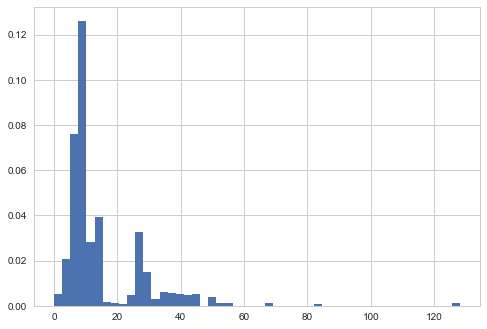

In [28]:
#sns.countplot(x='Fare_per_person', data=full_data[full_data['Embarked']=='S'])
full_data.Fare_per_person.hist(bins=50,density=True)

From here, we see that the distribution of fare per person is of a non-normal distribution. Therefore, best to use the median for each class as a representative statistic.

In [33]:
full_data.groupby(['Embarked','Pclass']).median().Fare_per_person
#.transform('median').Fare_per_person

Embarked  Pclass
C         1         34.6500
          2         13.8583
          3          7.2271
Q         1         30.0000
          2         12.3500
          3          7.7500
S         1         26.5500
          2         11.5000
          3          7.7958
Name: Fare_per_person, dtype: float64

From here, given that the fare_per_person for the two passengers in question was 40, their pclass was 1, it is likely they embarked from C. Let's go ahead and insert these values.

In [38]:
full_data.Embarked[full_data['PassengerId'].isin([62 ,830])]

61     NaN
829    NaN
Name: Embarked, dtype: object

In [41]:
full_data.Embarked[full_data['PassengerId'].isin([62 ,830])] = 'C'

C:\Users\rianashwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
full_data.Embarked[full_data['PassengerId'].isin([62 ,830])]

61     C
829    C
Name: Embarked, dtype: object

### 4.5 Missing Fare

In [43]:
full_data[full_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Pclass_Gender,Title,Family_size,Ticket_size,Group_size,Group_size_range,Fare_per_person
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,3male,Mr,1,1,1,single,NaN


Based on 4.4, we can estimate that this passenger likely had a a fare_per_person of 7.8. Let's go ahead and insert this value.

In [45]:
full_data[['Fare','Fare_per_person']][full_data['PassengerId']==1044]

,Fare,Fare_per_person
152,NaN,NaN


In [49]:
full_data['Fare_per_person'][full_data['PassengerId']==1044]=7.8
full_data['Fare'][full_data['PassengerId']==1044]=7.8

full_data[['Fare','Fare_per_person']][full_data['PassengerId']==1044]

C:\Users\rianashwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rianashwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Fare,Fare_per_person
152,7.8,7.8


### 4.6 Issues with Fare per person

In [53]:
full_data.Fare_per_person[full_data.Fare_per_person==0].count()

17

There are 17 passengers with Fare_per_person of 0. These could be due to passengers winning tickets, or just errors entirely. We need to deal with this, for risk of confusing our algorithms. There are two ways to handle this:

A) Replace with median for that embarcation and pclass, or
B) change fare per person into buckets.